In [ ]:
# krag 0.0.17 버전을 설치 (현재 버전을 사용할 경우 업데이트 차이에 따른 에러 발생)
!pip install krag==0.0.17

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## 문서 로드

In [2]:
from langchain.document_loaders import TextLoader
from langchain.schema import Document

# 메뉴판 텍스트 데이터를 로드
loader = TextLoader("./data/restaurant_menu.txt", encoding="utf-8")
documents = loader.load()

print(len(documents))

1


In [3]:
documents[0]

Document(metadata={'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.\n\n2. 트러플 리조또\n   • 가격: ₩22,000\n   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈\n   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.\n\n3. 연어 타르타르\n   • 가격: ₩18,000\n   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파\n   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이퍼, 적양파와 함께 섞어 만든 타르타르입니다. 레몬 드레싱으로 상큼한 맛을 더했으며, 바삭한 브리오쉬 토스트와 함께 제공됩니다. 전채요리로 완벽한 메뉴입니다.\n\n4. 버섯 크림 수프\n   • 가격: ₩10,000\n   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일\n   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝 뿌려 고급스러운 향을 더했습니다. 파슬리를 곱게 다져 고명으로 올려 제공됩니다.\n\n5. 가든 샐러드\n   • 가격: ₩12,000\n   • 주요 식재료: 유기농 믹스 그린, 체리 토마토, 오이, 당근, 발사

## 문서 분할 (Chunking)

In [4]:
import re
from langchain_core.documents import Document

def split_menu_items(document):
    # 메뉴 항목을 분리하기 위한 정규 표현식
    pattern = r'(\d+\.\s.*?)(?=\n\n\d+\.|$)'
    
    # 전체 텍스트에서 메뉴 항목 분리
    menu_items = re.findall(pattern, document.page_content, re.DOTALL)
    
    # 각 메뉴 항목을 Document 객체로 변환
    menu_documents = []
    for i, item in enumerate(menu_items, 1):
        # 메뉴 이름 추출
        menu_name = item.split('\n')[0].split('.', 1)[1].strip()
        
        # 새로운 Document 객체 생성
        menu_doc = Document(
            page_content=item.strip(),
            metadata={
                "source": document.metadata['source'],
                "menu_number": i,
                "menu_name": menu_name
            }
        )
        menu_documents.append(menu_doc)
    
    return menu_documents


# 메뉴 항목 분리 실행
menu_documents = []
for doc in documents:
    menu_documents += split_menu_items(doc)

# 결과 출력
print(f"총 {len(menu_documents)}개의 메뉴 항목이 처리되었습니다.")
for doc in menu_documents[:2]:
    print(f"\n메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print(f"내용:\n{doc.page_content[:100]}...")

총 10개의 메뉴 항목이 처리되었습니다.

메뉴 번호: 1
메뉴 이름: 시그니처 스테이크
내용:
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, ...

메뉴 번호: 2
메뉴 이름: 트러플 리조또
내용:
2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조...


## 문서 임베딩

In [5]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# OpenAI Embeddings 모델 로드
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# 유클리드 거리를 사용하는 Chroma 인덱스 생성
db_chroma = Chroma.from_documents(
    documents=menu_documents, 
    embedding=embeddings_model,   
    collection_name="restaurant_menu_openai_db",
    persist_directory="./chroma_db",
)

In [6]:
# 검색기 초기화 (k=3)

retriever_chroma = db_chroma.as_retriever(
    search_kwargs = {"k": 3}
)

# 검색 실행
query = "스테이크 메뉴를 추천해주세요"
docs = retriever_chroma.invoke(query)
print(f"검색 결과 (L2 거리): {len(docs)}개")

for doc in docs:
    print(f"메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")

검색 결과 (L2 거리): 3개
메뉴 번호: 8
메뉴 이름: 안심 스테이크 샐러드
메뉴 번호: 1
메뉴 이름: 시그니처 스테이크
메뉴 번호: 7
메뉴 이름: 랍스터 비스크


In [7]:
from krag.tokenizers import KiwiTokenizer
from krag.retrievers import KiWiBM25RetrieverWithScore

# BM25 검색기 초기화 (k=3)
retriever_bm25 = KiWiBM25RetrieverWithScore(
    documents=menu_documents, 
    kiwi_tokenizer=KiwiTokenizer(model_type='knlm', typos='basic'), 
    k=3, 
)       

# 검색 실행
query = "스테이크 메뉴를 추천해주세요"
docs = retriever_bm25.invoke(query)
print(f"검색 결과 (BM25): {len(docs)}개")

for doc in docs:
    print(f"메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")

검색 결과 (BM25): 3개
메뉴 번호: 8
메뉴 이름: 안심 스테이크 샐러드
메뉴 번호: 5
메뉴 이름: 가든 샐러드
메뉴 번호: 1
메뉴 이름: 시그니처 스테이크


## 검색 성능 테스트

In [8]:
# 테스트 데이터 로드
import pandas as pd
df_test = pd.read_csv("./data/restaurant_menu_test_data.csv")

print("테스트 데이터 갯수:", len(df_test))
df_test.columns = ['menu_name', 'question', 'answer']

df_test.head()

테스트 데이터 갯수: 15


,menu_name,question,answer
0,시그니처 스테이크,이 레스토랑의 대표 메뉴로 알려진 고기 요리의 가격은 얼마인가요?,"시그니처 스테이크의 가격은 ₩35,000입니다."
1,트러플 리조또,이탈리아 쌀요리 중 가장 비싼 메뉴는 무엇인가요?,"트러플 리조또로, 가격은 ₩22,000입니다."
2,연어 타르타르,차가운 해산물 요리 중 가장 인기 있는 메뉴의 주요 재료는 무엇인가요?,"연어 타르타르의 주요 식재료는 노르웨이산 생연어, 아보카도, 케이퍼, 적양파입니다."
3,버섯 크림 수프,버섯을 주재료로 한 따뜻한 수프 메뉴가 있나요? 있다면 가격은 얼마인가요?,"네, 버섯 크림 수프가 있습니다. 가격은 ₩10,000입니다."
4,가든 샐러드,채식주의자를 위한 메인 요리로 추천할 만한 메뉴가 있나요?,"가든 샐러드를 추천할 수 있습니다. 유기농 믹스 그린, 체리 토마토, 오이, 당근..."


In [9]:
# 메뉴 이름으로 메뉴 항목 검색

def find_content_by_menu_name(menu_name):
    for doc in menu_documents:
        if doc.metadata['menu_name'].strip() == menu_name.strip():
            return doc.page_content
    return None

# 검색 테스트
menu_name = "시그니처 스테이크"
content = find_content_by_menu_name(menu_name)
print(f"메뉴 내용:\n{content}")

메뉴 내용:
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.


In [10]:
# df_test의 각 행별 컨텍스트 문서를 찾아서 Document 객체로 변환

def create_context_docs(df_test, idx):
    menu_name = df_test['menu_name'].iloc[idx]
    context = find_content_by_menu_name(menu_name)
    context_document = Document(page_content=context, metadata={"menu_name": menu_name})
    return [context_document]

# 문서 객체로 변환
context_docs = create_context_docs(df_test, 0)
context_docs

[Document(metadata={'menu_name': ' 시그니처 스테이크 '}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.')]

In [11]:
df_test['question'].iloc[0]

' 이 레스토랑의 대표 메뉴로 알려진 고기 요리의 가격은 얼마인가요? '

In [12]:
# 검색어 설청
question = df_test['question'].iloc[0]

# 정답 컨텍스트 문서
context_docs = create_context_docs(df_test, 0)

# 문서 검색
docs_bm25 = retriever_bm25.invoke(question)
docs_chroma = retriever_chroma.invoke(question)

# 평가도구 초기화 
from krag.evaluators import OfflineRetrievalEvaluators
evaluator_bm25 = OfflineRetrievalEvaluators(
    actual_docs=[context_docs], 
    predicted_docs=[docs_bm25], 
    )

evaluator_chroma = OfflineRetrievalEvaluators(
    actual_docs=[context_docs], 
    predicted_docs=[docs_chroma], 
    )

# Hit Rate 계산 
hit_rate_bm25 = evaluator_bm25.calculate_hit_rate()
hit_rate_chroma = evaluator_chroma.calculate_hit_rate()

# 결과 출력
print(f"Hit Rate (BM25): {hit_rate_bm25}")
print(f"Hit Rate (Chroma): {hit_rate_chroma}")


Hit Rate (BM25): 1.0
Hit Rate (Chroma): 1.0


In [13]:
# MRR 계산
mrr_bm25 = evaluator_bm25.calculate_mrr()
mrr_chroma = evaluator_chroma.calculate_mrr()

# 결과 출력
print(f"MRR (BM25): {mrr_bm25}")
print(f"MRR (Chroma): {mrr_chroma}")

MRR (BM25): 0.5
MRR (Chroma): 1.0


In [14]:
# 전체 테스트 데이터에 대한 평가

def evaluate_test(df_test, bm25_retriever, chrom_retriever):
    hit_rates_bm25 = []
    hit_rates_chroma = []

    mrrs_bm25 = []
    mrrs_chroma = []

    for i in range(len(df_test)):
        # 검색어 추출
        question = df_test['question'].iloc[i]

        # 정답 컨텍스트 문서
        context_docs = create_context_docs(df_test, i)

        # 문서 검색
        docs_bm25 = bm25_retriever.invoke(question)
        docs_chroma = chrom_retriever.invoke(question)

        # 평가도구 초기화
        evaluator_bm25 = OfflineRetrievalEvaluators(
            actual_docs=[context_docs], 
            predicted_docs=[docs_bm25], 
        )

        evaluator_chroma = OfflineRetrievalEvaluators(
            actual_docs=[context_docs], 
            predicted_docs=[docs_chroma], 
        )

        # Hit Rate 계산
        hit_rate_bm25 = evaluator_bm25.calculate_hit_rate()
        hit_rate_chroma = evaluator_chroma.calculate_hit_rate()

        # MRR 계산
        mrr_bm25 = evaluator_bm25.calculate_mrr()
        mrr_chroma = evaluator_chroma.calculate_mrr()

        # 결과 저장
        hit_rates_bm25.append(hit_rate_bm25)
        hit_rates_chroma.append(hit_rate_chroma)

        mrrs_bm25.append(mrr_bm25)
        mrrs_chroma.append(mrr_chroma)

    # 평균 Hit Rate 계산
    mean_hit_rate_bm25 = sum(hit_rates_bm25) / len(hit_rates_bm25)
    mean_hit_rate_chroma = sum(hit_rates_chroma) / len(hit_rates_chroma)

    # 평균 MRR 계산
    mean_mrr_bm25 = sum(mrrs_bm25) / len(mrrs_bm25)
    mean_mrr_chroma = sum(mrrs_chroma) / len(mrrs_chroma)

    # 결과 출력
    print(f"평균 Hit Rate (BM25): {mean_hit_rate_bm25}")
    print(f"평균 Hit Rate (Chroma): {mean_hit_rate_chroma}")

    print(f"평균 MRR (BM25): {mean_mrr_bm25}")
    print(f"평균 MRR (Chroma): {mean_mrr_chroma}")

    # 평가결과를 데이터프레임으로 변환
    df_eval = pd.DataFrame({
        "hit_rate_bm25": hit_rates_bm25,
        "hit_rate_chroma": hit_rates_chroma,
        "mrr_bm25": mrrs_bm25,
        "mrr_chroma": mrrs_chroma
    })


    return df_eval


# 전체 테스트 데이터에 대한 평가 실행
df_eval = evaluate_test(df_test, retriever_bm25, retriever_chroma)
df_eval.head()

평균 Hit Rate (BM25): 0.8
평균 Hit Rate (Chroma): 0.6666666666666666
평균 MRR (BM25): 0.5888888888888889
평균 MRR (Chroma): 0.4777777777777778


,hit_rate_bm25,hit_rate_chroma,mrr_bm25,mrr_chroma
0,1.0,1.0,0.500000,1.000000
1,1.0,1.0,1.000000,0.333333
2,0.0,1.0,0.000000,0.500000
3,1.0,1.0,1.000000,1.000000
4,1.0,0.0,0.333333,0.000000


## 일반적인 Text Splitter 적용했을 때 검색 성능

In [15]:
from krag.evaluators import RougeOfflineRetrievalEvaluators

def evaluate_test_rouge(df_test, bm25_retriever, chrom_retriever):
    hit_rates_bm25 = []
    hit_rates_chroma = []

    mrrs_bm25 = []
    mrrs_chroma = []

    for i in range(len(df_test)):
        # 검색어 추출
        question = df_test['question'].iloc[i]

        # 정답 컨텍스트 문서
        context_docs = create_context_docs(df_test, i)

        # 문서 검색
        docs_bm25 = bm25_retriever.invoke(question)
        docs_chroma = chrom_retriever.invoke(question)

        # ROUGE 매칭을 사용한 평가도구 초기화 
        evaluator_bm25 = RougeOfflineRetrievalEvaluators(
            actual_docs=[context_docs], 
            predicted_docs=[docs_bm25], 
            match_method="rouge1", 
            threshold=0.6,
        )

        evaluator_chroma = RougeOfflineRetrievalEvaluators(
            actual_docs=[context_docs], 
            predicted_docs=[docs_chroma], 
            match_method="rouge1", 
            threshold=0.6,            
        )

        # Hit Rate 계산
        hit_rate_bm25 = evaluator_bm25.calculate_hit_rate()
        hit_rate_chroma = evaluator_chroma.calculate_hit_rate()

        # MRR 계산
        mrr_bm25 = evaluator_bm25.calculate_mrr()
        mrr_chroma = evaluator_chroma.calculate_mrr()

        # 결과 저장
        hit_rates_bm25.append(hit_rate_bm25)
        hit_rates_chroma.append(hit_rate_chroma)

        mrrs_bm25.append(mrr_bm25)
        mrrs_chroma.append(mrr_chroma)

    # 평균 Hit Rate 계산
    mean_hit_rate_bm25 = sum(hit_rates_bm25) / len(hit_rates_bm25)
    mean_hit_rate_chroma = sum(hit_rates_chroma) / len(hit_rates_chroma)

    # 평균 MRR 계산
    mean_mrr_bm25 = sum(mrrs_bm25) / len(mrrs_bm25)
    mean_mrr_chroma = sum(mrrs_chroma) / len(mrrs_chroma)

    # 결과 출력
    print(f"평균 Hit Rate (BM25): {mean_hit_rate_bm25}")
    print(f"평균 Hit Rate (Chroma): {mean_hit_rate_chroma}")

    print(f"평균 MRR (BM25): {mean_mrr_bm25}")
    print(f"평균 MRR (Chroma): {mean_mrr_chroma}")

    # 평가결과를 데이터프레임으로 변환
    df_eval = pd.DataFrame({
        "hit_rate_bm25": hit_rates_bm25,
        "hit_rate_chroma": hit_rates_chroma,
        "mrr_bm25": mrrs_bm25,
        "mrr_chroma": mrrs_chroma
    })


    return df_eval

In [16]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50,
)

split_docs = text_splitter.split_documents(documents)

len(split_docs)

16

In [17]:
print(split_docs[0].page_content)

1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스


In [18]:
print(split_docs[1].page_content)

• 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.


In [19]:
# 벡터 임베딩
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# OpenAI Embeddings 모델 로드
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# 유클리드 거리를 사용하는 Chroma 인덱스 생성
db_chroma_split = Chroma.from_documents(
    documents=split_docs, 
    embedding=embeddings_model,   
    collection_name="restaurant_menu_chumk200_db",
    persist_directory="./chroma_db",
)

In [20]:
# 검색기 초기화 (k=3)
retriever_chroma_split = db_chroma_split.as_retriever(
    search_kwargs = {"k": 3}
)

In [21]:
from krag.tokenizers import KiwiTokenizer
from krag.retrievers import KiWiBM25RetrieverWithScore

# BM25 검색기 초기화 (k=3)
retriever_bm25_split = KiWiBM25RetrieverWithScore(
    documents=split_docs, 
    kiwi_tokenizer=KiwiTokenizer(model_type='knlm', typos='basic'), 
    k=3, 
)       

In [22]:
# 전체 테스트 데이터에 대한 평가 실행
df_eval_chunk_250 = evaluate_test_rouge(df_test, retriever_bm25_split, retriever_chroma_split)
df_eval_chunk_250.head()

평균 Hit Rate (BM25): 0.6666666666666666
평균 Hit Rate (Chroma): 0.6
평균 MRR (BM25): 0.4222222222222222
평균 MRR (Chroma): 0.4444444444444445


,hit_rate_bm25,hit_rate_chroma,mrr_bm25,mrr_chroma
0,1.0,0.0,0.500000,0.000000
1,1.0,0.0,0.500000,0.000000
2,0.0,1.0,0.000000,0.333333
3,0.0,1.0,0.000000,0.333333
4,1.0,1.0,0.333333,0.500000


In [23]:
docs = retriever_bm25_split.invoke("이 레스토랑의 대표 메뉴로 알려진 고기 요리의 가격은 얼마인가요?")
for doc in docs:
    print(doc)

page_content='• 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.' metadata={'source': './data/restaurant_menu.txt', 'bm25_score': 6.746306799129181}
page_content='• 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.' metadata={'source': './data/restaurant_menu.txt', 'bm25_score': 5.459354624701536}
page_content='6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.' metadata={'source': './data/restaurant_menu.txt', 'bm25_score': 5.03803657775352}


In [24]:
# 각 방식의 평균 Hit Rate 및 MRR 계산해서 데이터프레임으로 변환
df_eval_mean = df_eval.mean().to_frame().T
df_eval_chunk_250_mean = df_eval_chunk_250.mean().to_frame().T

# 병합
df_eval_all = pd.concat([df_eval_mean, df_eval_chunk_250_mean], axis=0)
df_eval_all.index = ['structure', 'simple']

df_eval_all

,hit_rate_bm25,hit_rate_chroma,mrr_bm25,mrr_chroma
structure,0.800000,0.666667,0.588889,0.477778
simple,0.666667,0.600000,0.422222,0.444444


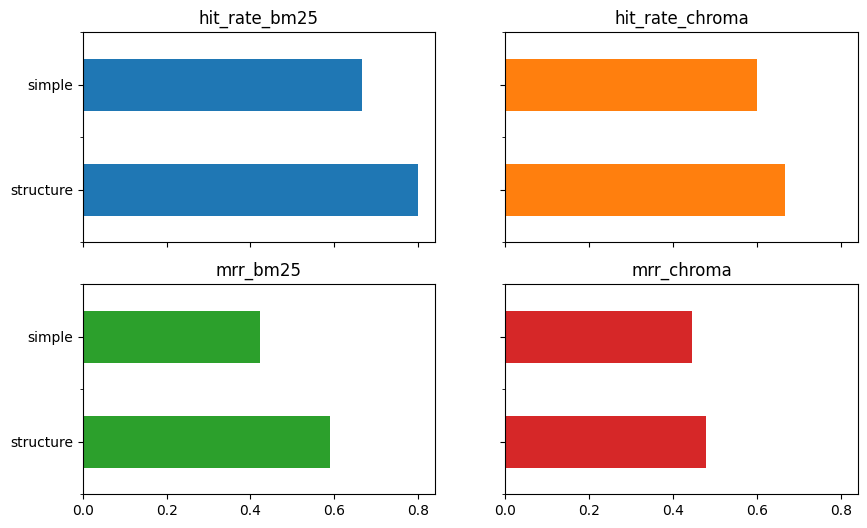

In [35]:
# 시각화: 각 성능 지표별로 막대 그래프 생성
df_eval_all.plot(kind='barh', figsize=(10, 6), subplots=True, layout=(2, 2), sharey=True, legend=False);

## 앙상블 검색기

In [36]:
from langchain.retrievers import EnsembleRetriever

def evaluate_ensmeble(ensemble_retriever):

    # 전체 테스트 데이터에 대한 평가 실행
    hit_rate_ensemble = []
    mrr_ensemble = []

    for i in range(len(df_test)):
        # 검색어 추출
        question = df_test['question'].iloc[i]

        # 정답 컨텍스트 문서
        context_docs = create_context_docs(df_test, i)

        # 문서 검색
        docs_ensemble = ensemble_retriever.invoke(question)

        # 평가도구 초기화
        evaluator_ensemble = RougeOfflineRetrievalEvaluators(
            actual_docs=[context_docs], 
            predicted_docs=[docs_ensemble], 
            match_method="rouge1", 
            threshold=0.6,
        )

        # Hit Rate 계산
        hit_rate_ensemble.append(evaluator_ensemble.calculate_hit_rate())

        # MRR 계산
        mrr_ensemble.append(evaluator_ensemble.calculate_mrr())

    # 평균 Hit Rate 계산
    mean_hit_rate_ensemble = sum(hit_rate_ensemble) / len(hit_rate_ensemble)

    # 평균 MRR 계산
    mean_mrr_ensemble = sum(mrr_ensemble) / len(mrr_ensemble)

    # 결과 출력
    print(f"평균 Hit Rate (Ensemble): {mean_hit_rate_ensemble}")
    print(f"평균 MRR (Ensemble): {mean_mrr_ensemble}")

    # 평가결과를 데이터프레임으로 변환
    df_eval_ensemble = pd.DataFrame({
        "hit_rate_ensemble": hit_rate_ensemble,
        "mrr_ensemble": mrr_ensemble,
    })

    return df_eval_ensemble

# 앙상블 검색기 초기화
ensemble_retriever = EnsembleRetriever(
    retrievers=[retriever_bm25, retriever_chroma], 
    weights=[0.5, 0.5],
)

# 앙상블 검색기 평가
df_eval_ensemble_structure = evaluate_ensmeble(ensemble_retriever)
df_eval_ensemble_structure.head()


평균 Hit Rate (Ensemble): 0.9333333333333333
평균 MRR (Ensemble): 0.5722222222222223


,hit_rate_ensemble,mrr_ensemble
0,1.0,0.500000
1,1.0,1.000000
2,1.0,0.333333
3,1.0,1.000000
4,1.0,0.250000


In [37]:
# 앙상블 검색기 초기화
ensemble_retriever_split = EnsembleRetriever(
    retrievers=[retriever_bm25_split, retriever_chroma_split], 
    weights=[0.5, 0.5],
)

# 앙상블 검색기 평가
df_eval_ensemble_simple = evaluate_ensmeble(ensemble_retriever_split)
df_eval_ensemble_simple.head()

평균 Hit Rate (Ensemble): 0.8666666666666667
평균 MRR (Ensemble): 0.5133333333333333


,hit_rate_ensemble,mrr_ensemble
0,1.0,0.500000
1,1.0,0.250000
2,1.0,0.200000
3,1.0,0.166667
4,1.0,0.500000


In [38]:
# 기존 평가결과와 결합
df_eval_all['hit_rate_ensemble'] = [
    df_eval_ensemble_structure['hit_rate_ensemble'].mean(),
    df_eval_ensemble_simple['hit_rate_ensemble'].mean(),
]

df_eval_all['mrr_ensemble'] = [
    df_eval_ensemble_structure['mrr_ensemble'].mean(),
    df_eval_ensemble_simple['mrr_ensemble'].mean(),
]

df_eval_all = df_eval_all[['hit_rate_bm25', 'hit_rate_chroma', 'hit_rate_ensemble', 'mrr_bm25', 'mrr_chroma', 'mrr_ensemble']]
df_eval_all

,hit_rate_bm25,hit_rate_chroma,hit_rate_ensemble,mrr_bm25,mrr_chroma,mrr_ensemble
structure,0.800000,0.666667,0.933333,0.588889,0.477778,0.572222
simple,0.666667,0.600000,0.866667,0.422222,0.444444,0.513333


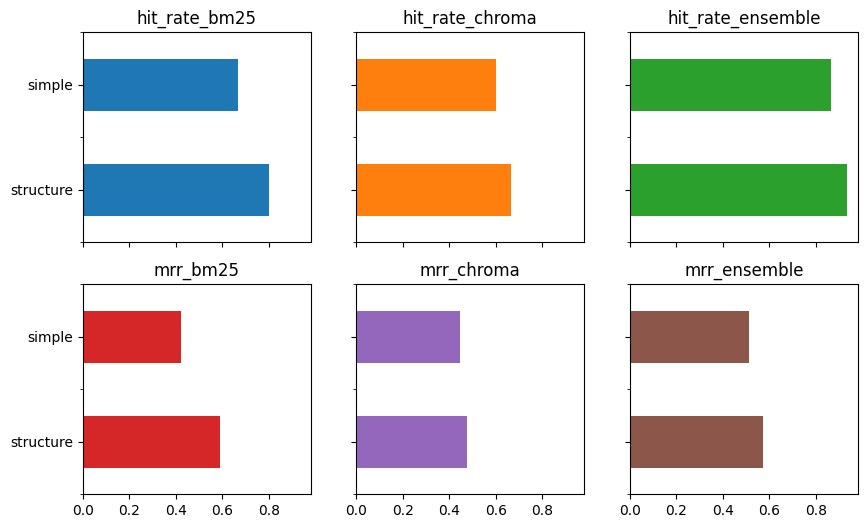

In [39]:
# 시각화: 각 성능 지표별로 막대 그래프 생성
df_eval_all.plot(kind='barh', figsize=(10, 6), subplots=True, layout=(2, 3), sharey=True, legend=False);

# RAG 체인을 Gradio로 구현

In [44]:
import gradio as gr
from typing import List, Tuple

from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

from sentence_transformers import CrossEncoder

# 프롬프트 템플릿
template = """Use the following pieces of context to answer the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Answer: """
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"], template=template)


# 검색기와 언어 모델을 사용한 QA 체인 초기화
qa_chain = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(model_name="gpt-4o-mini", temperature=0),  # 언어 모델 설정
    chain_type="stuff",  # QA 체인 유형 설정
    retriever=ensemble_retriever,  # 사전에 정의된 검색기 사용
    return_source_documents=True,  # 소스 문서 반환 설정
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}  # 프롬프트 템플릿 사용
)


# Cross Endocer 모델 초기화
cross_encoder_model = CrossEncoder("BAAI/bge-reranker-v2-m3")

# 답변 하이라이트 함수
def highlight_answer_in_context(answer: str, context: str, threshold: float = 0.5) -> str:

    # 컨텍스트를 문장으로 분리
    sentences = context.split("\n\n")
    
    # 각 문장과 답변 사이의 유사도 계산
    similarities = cross_encoder_model.predict([(answer, sent) for sent in sentences])
    
    # 하이라이트된 컨텍스트 생성
    highlighted_context = ""
    for sent, sim in zip(sentences, similarities):
        if sim > threshold:
            highlighted_context += f"<mark>{sent}</mark> "
        else:
            highlighted_context += sent + " "
    
    return highlighted_context.strip()

# 챗봇 쿼리 처리 함수
def process_query(query: str) -> Tuple[str, List[str]]:
    result = qa_chain({"query": query})
    answer = result['result']
    source_documents = result['source_documents']
    
    # 소스 문서에서 답변과 관련된 부분 하이라이트
    highlighted_docs = []
    for doc in source_documents:
        highlighted_content = highlight_answer_in_context(answer, doc.page_content)
        highlighted_docs.append(highlighted_content)
    
    return answer, highlighted_docs

# 챗봇 대화 함수
def chat(message, history):
    answer, highlighted_docs = process_query(message)
    response = f"답변: {answer}\n\n참조:\n"
    for i, doc in enumerate(highlighted_docs, 1):
        response += f"\n{i}. {doc}\n"
    return response

# Gradio 챗봇 인터페이스 초기화 및 실행
iface = gr.ChatInterface(
    chat,
    chatbot=gr.Chatbot(height=500, render_markdown=True),
    textbox=gr.Textbox(placeholder="질문을 입력하세요", container=False, scale=7),
    title="레스토랑 메뉴 QA 챗봇",
    description="레스토랑 메뉴에 대해 질문해보세요.",
    theme="soft",
    examples=[
        "이 레스토랑의 시그니처 메뉴는 무엇인가요?",
        "연어 요리는 무엇이고 가격은 얼마인가요?",
        "채식주의자를 위한 메뉴 추천해주세요.",
    ],
    cache_examples=False,
    retry_btn=None,
    undo_btn="이전 삭제",
    clear_btn="모두 지우기",
)

iface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [43]:
iface.close()

Closing server running on port: 7860
